# Import Packages

In [ ]:
!pip install text2emotion
!pip install raceplotly
!pip install yfinance
!pip install pandas-datareader
!pip install vaderSentiment
!pip install spacy
!pip install wordcloud
!pip install scipy
!pip install scikit-learn
!pip install seaborn
!pip install XGBoost

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr
import math
from scipy.stats import pearsonr
import numpy as np
import datetime
import yfinance as yf
pd.core.common.is_list_like = pd.api.types.is_list_like

from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import spacy as sp
import nltk
import text2emotion as te
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from raceplotly.plots import barplot

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Import Dataset

In [ ]:
df = pd.read_csv("reddit_wsb.csv")
df.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

                                                 url  comms_num       created  \
0                    https://v.redd.it/6j75regs72e61          6  1.611863e+09   
1                    https://v.redd.it/ah50lyny62e61         23  1.611862e+09   
2  https://www.reddit.com/r/wallstreetbets/commen...         47  1.611862e+09   
3  https://sec.report/Document/0001193125-21-019848/         74  1.611862e+09   
4                https://i.redd.it/4h2sukb662e61.jpg        156  1.611862e+09   

                                                body            timestamp  
0                                                NaN  2021-01-28 21:37:41  
1                                                NaN  2021-01-28 21:32:10  
2  The CEO of NASDAQ pushed to halt trading “to g...  2021-01-28 21:30:35  
3                                                NaN  2021-01-28 21:28:57  
4                                                NaN  2021-01-28 21:26:56

In [ ]:
# Column names
df.columns.tolist()

## Remove Unnecessary Columns

In [ ]:
df.drop(['url', 'created'], axis=1, inplace=True)

In [ ]:
df.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

   comms_num                                               body  \
0          6                                                NaN   
1         23                                                NaN   
2         47  The CEO of NASDAQ pushed to halt trading “to g...   
3         74                                                NaN   
4        156                                                NaN   

             timestamp  
0  2021-01-28 21:37:41  
1  2021-01-28 21:32:10  
2  2021-01-28 21:30:35  
3  2021-01-28 21:28:57  
4  2021-01-28 21:26:56

# EDA

## Average Length of Post Title

In [ ]:
# Average length of post title
# Create temporary df1 to store 'len' column
df1 = df.copy()
df1['len']=df1['title'].apply(lambda x : len(x.split(' ')))
display(px.histogram(df1['len'],template='plotly_white', title='Length of Post Titles'))
print(f"Average Length of Post Title: {round(df1['len'].mean(), 2)}")

Average Length of Post Title: 10.87


## Average Length of Post Body

In [ ]:
# Average length of post body
df1['len']=df1['body'].astype(str).apply(lambda x : len(x.split(' ')))
display(px.histogram(df1['len'],template='plotly_white', title='Length of Post Body'))
print(f"Average Length of Post Body: {round(df1['len'].mean(), 2)}")

Average Length of Post Body: 99.64


## Average Upvotes per Post

In [ ]:
# Average upvotes per post
# Trim outliers, we can disregard top 10% of posts as outliers
upper = df.score.quantile(.90)
df_trimmed = df[df['score'] <= upper]

display(px.histogram(df_trimmed, x=df_trimmed.score, labels={'score':'upvotes'}, nbins=50, title="Distribution of Upvotes Across Majority of Posts"))
print(f"Average Upvotes Per Post: {round(df['score'].mean(), 2)}")

Average Upvotes Per Post: 1382.46


# Sentiment Classification

In [ ]:
analyzer = SentimentIntensityAnalyzer()

#1. Create overall text column
df['overall text'] = df['title'] + " " + df["body"].astype(str)

# explain: concatenates the 'title' and 'body' columns into a new column called 'overall text'.


#2. Define a function to get sentiment scores
def get_sentiment_scores(text):
    return analyzer.polarity_scores(text)

# Apply VADER to the 'overall text' column to get sentiment scores
df['sentiment_scores'] = df['overall text'].apply(get_sentiment_scores)

# explaination: returns the sentiment scores using the polarity_scores method of the SentimentIntensityAnalyzer object

#3. Extract sentiment categories (positive, neutral, negative) based on compound score
def get_sentiment_category(scores):
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Create new column showing sentiment classification of that row
df['sentiment_category'] = df['sentiment_scores'].apply(get_sentiment_category)


# Creating new date and time columns
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
df['timestamp']=pd.to_datetime(df['timestamp'])
df['month']=df['timestamp'].dt.month
df['day']=df['timestamp'].dt.day
df['hour']=df['timestamp'].dt.hour
df['weekday']=df['timestamp'].dt.weekday
df['weekday']=df['weekday'].apply(lambda x: day_name[x])

In [ ]:
df['overall text']

0        It's not about the money, it's about sending a...
1        Math Professor Scott Steiner says the numbers ...
2        Exit the system The CEO of NASDAQ pushed to ha...
3        NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...
4        Not to distract from GME, just thought our AMC...
                               ...                        
53182    What I Learned Investigating SAVA FUD Spreader...
53183    Daily Popular Tickers Thread for August 02, 20...
53184     Hitler reacts to the market being irrational nan
53185    Daily Discussion Thread for August 02, 2021 Yo...
53186    Fraternal Association of Gambling Gentlemen an...
Name: overall text, Length: 53187, dtype: object

In [ ]:
df.head()

title  score      id  \
0  It's not about the money, it's about sending a...     55  l6ulcx   
1  Math Professor Scott Steiner says the numbers ...    110  l6uibd   
2                                    Exit the system      0  l6uhhn   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...     29  l6ugk6   
4  Not to distract from GME, just thought our AMC...     71  l6ufgy   

   comms_num                                               body  \
0          6                                                NaN   
1         23                                                NaN   
2         47  The CEO of NASDAQ pushed to halt trading “to g...   
3         74                                                NaN   
4        156                                                NaN   

            timestamp                                       overall text  \
0 2021-01-28 21:37:41  It's not about the money, it's about sending a...   
1 2021-01-28 21:32:10  Math Professor Scott Steiner says the numbers ...   
2 2021-01-28 21:30:35  Exit the system The CEO of NASDAQ pushed to ha...   
3 2021-01-28 21:28:57  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...   
4 2021-01-28 21:26:56  Not to distract from GME, just thought our AMC...   

                                    sentiment_scores sentiment_category  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...            neutral   
1  {'neg': 0.287, 'neu': 0.713, 'pos': 0.0, 'comp...           negative   
2  {'neg': 0.071, 'neu': 0.88, 'pos': 0.049, 'com...           negative   
3  {'neg': 0.256, 'neu': 0.594, 'pos': 0.15, 'com...           negative   
4  {'neg': 0.0, 'neu': 0.888, 'pos': 0.112, 'comp...           positive   

   month  day  hour   weekday  
0      1   28    21  Thursday  
1      1   28    21  Thursday  
2      1   28    21  Thursday  
3      1   28    21  Thursday  
4      1   28    21  Thursday

In [ ]:
df[['overall text','sentiment_scores','sentiment_category']].head()

overall text  \
0  It's not about the money, it's about sending a...   
1  Math Professor Scott Steiner says the numbers ...   
2  Exit the system The CEO of NASDAQ pushed to ha...   
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...   
4  Not to distract from GME, just thought our AMC...   

                                    sentiment_scores sentiment_category  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...            neutral  
1  {'neg': 0.287, 'neu': 0.713, 'pos': 0.0, 'comp...           negative  
2  {'neg': 0.071, 'neu': 0.88, 'pos': 0.049, 'com...           negative  
3  {'neg': 0.256, 'neu': 0.594, 'pos': 0.15, 'com...           negative  
4  {'neg': 0.0, 'neu': 0.888, 'pos': 0.112, 'comp...           positive

## Posts per Weekday

In [ ]:
# Graph of posts per weekday
px.histogram(df, x='weekday', color='weekday', template='plotly_white', category_orders={'weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

## Sentiment per Weekday

In [ ]:
# df1 represents count of sentiment for each weekday
df1=pd.DataFrame()
df1['Sentiment']=df['sentiment_category']
df1['Day']=df['weekday']
df1['Count']=[1]*len(df)

# group df1 to get sum of sentiment per weekday
grouped_df=df1.groupby(['Day','Sentiment']).sum()
ind=np.array(list(grouped_df.index))

# create another df2 to use for visualization based off df1
df2=pd.DataFrame()
df2['Day']=ind[:,0]
df2['Sentiment']=ind[:,1]
df2['Count']=grouped_df.values
my_raceplot = barplot(df2,
                      item_column='Sentiment',
                      value_column='Count',
                      time_column='Day')


# use plotly raceplot to plot sentiment over each weekday
my_raceplot.plot(title = 'Sentiment in the sub reddit section',
                 item_label = 'Sentiment',
                 value_label = 'Count (Total Count On That Day)',
                 frame_duration = 1500)

In [ ]:
#'df1' represents count of sentiment for each weekday
# Convert 'Day' column to categorical with desired order
df1['Day'] = pd.Categorical(df1['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Group df1 to get sum of sentiment per weekday
grouped_df = df1.groupby(['Day', 'Sentiment']).sum().reset_index()

# Manually specify the order of the days of the week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the stacked bar plot
fig = go.Figure()

# Iterate over each sentiment category
for sentiment in grouped_df['Sentiment'].unique():
    data = grouped_df[grouped_df['Sentiment'] == sentiment]
    fig.add_trace(go.Bar(x=data['Day'], y=data['Count'], name=sentiment))

# Update layout
fig.update_layout(barmode='stack', template='plotly_white',
                  title='Sentiment in the subreddit section',
                  xaxis_title='Day', yaxis_title='Count (Total Count On That Day)',
                  xaxis={'categoryorder':'array', 'categoryarray':day_order})

# Show the plot
fig.show()

# WSB Sentiment vs GME Price Movement During GME Skyrocket Period

In [ ]:
# GME time period
start_date = '2021-01-01'
end_date = '2021-04-01'

# Filter posts within the specified time period
posts_within_time_period = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# Extract the top 10 posts with the highest scores within the specified time period
top_5_posts_within_time_period = posts_within_time_period.nlargest(5, 'score')


# Create a bar plot to visualize the scores of the top 10 posts within the specified time period
fig = px.bar(top_5_posts_within_time_period, x='title', y='score',
             title=f'Top 5 Posts by Score ({start_date} to {end_date})',
             labels={'title': 'Post Title', 'score': 'Upvote'})

# Rotate x-axis labels to avoid overlap
fig.update_layout(xaxis_tickangle=-55)

# Adjust the size of the plot
fig.update_layout(height=600, width=800)


# Show the plot
fig.show()

In [ ]:
# establish time period of interest
start = '2021-01-01'
end = '2021-04-17'

# filter df to see only rows where "gme" is mentioned
gme_df = df[(df['overall text'].str.contains('deepfuckingvalue', case=False)) &
            (df['timestamp'] >= start) &
            (df['timestamp'] <= end)]

# create majority sentiment of each day
sentiment_aggregated = gme_df.groupby(gme_df['timestamp'].dt.date)['sentiment_category'].value_counts().unstack(fill_value=0)
sentiment_aggregated['majority_sentiment'] = sentiment_aggregated.idxmax(axis=1)

# reorder sentiment
sentiment_order = ['positive', 'neutral', 'negative']
sentiment_aggregated = sentiment_aggregated.reindex(sentiment_order, axis=1)

# download gme price chart data using yfinance
gme_data = yf.download('GME', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# make subplots to visualize both sentiment graph and price movement of GME
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add GME price data to the first subplot
fig.add_trace(go.Scatter(x=gme_data.index, y=gme_data['Close'], mode='lines', name='GME Price'), row=1, col=1)
# Set y-axis title for the first subplot
fig.update_yaxes(title_text='GME Price', row=1, col=1)

# Plot sentiment scores on the second subplot
for sentiment_category in sentiment_order:
    fig.add_trace(go.Scatter(x=sentiment_aggregated.index, y=sentiment_aggregated[sentiment_category], mode='markers', name=sentiment_category.capitalize()), row=2, col=1)

# Set y-axis title for the second subplot
fig.update_yaxes(title_text='Majority Sentiment', row=2, col=1)

# Update layout
fig.update_layout(title='GME Price and Majority Sentiment (Jan 2021 - April 2021)')

# Show plot
fig.show()

* Our dataset starts on 2021-01-28 so we cannot infer any sentiment before that time
### Correlation Analysis

In [ ]:
# Convert sentiment to numerical
sentiment_aggregated['majority_sentiment'] = sentiment_aggregated.idxmax(axis=1)
sentiment_numerical = sentiment_aggregated['majority_sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': -1})

# Ensure both datasets have the same index
gme_data.index = pd.to_datetime(gme_data.index)
sentiment_numerical.index = pd.to_datetime(sentiment_numerical.index)

# Resample both datasets to have daily data
gme_daily = gme_data['Close'].resample('D').mean()
sentiment_daily = sentiment_numerical.resample('D').mean()

# Conduct correlation analysis
correlation_gme = gme_daily.corr(sentiment_daily)
print("Correlation between GME stock price and sentiment:", correlation_gme)


Correlation between GME stock price and sentiment: 0.09526696005423195


### Regression Analysis

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data
X = sentiment_numerical.values.reshape(-1, 1)  # Feature: Sentiment
y = gme_daily.values  # Target: GME stock price

# Ensure both X and y have the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.impute import SimpleImputer

# Impute missing values in y_train using mean imputation
imputer = SimpleImputer(strategy='mean')
y_train_imputed = imputer.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_imputed = imputer.fit_transform(y_test.reshape(-1, 1)).ravel()

# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_imputed)
y_pred_linear = linear_reg.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test_imputed, y_pred_linear)
r2_linear = r2_score(y_test_imputed, y_pred_linear)
print("Linear Regression Mean Squared Error:", mse_linear)
print("Linear Regression R^2 Score:", r2_linear)

# XGboost
xgb = XGBRegressor()
xgb.fit(X_train, y_train_imputed)
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test_imputed, y_pred_xgb)
r2_xgb = r2_score(y_test_imputed, y_pred_xgb)
print("XGBoost Mean Squared Error:", mse_xgb)
print("XGBoost R^2 Score:", r2_xgb)

Linear Regression Mean Squared Error: 123.37159204953542
Linear Regression R^2 Score: -0.04419995856719883
XGBoost Mean Squared Error: 123.37132165945883
XGBoost R^2 Score: -0.04419767002327979


# WSB Sentiment vs AMC Price Movement During AMC Skyrocket Period

In [ ]:
# AMC time period
start_date = '2021-05-01'
end_date = '2021-08-16'

# Filter posts within the specified time period
posts_within_time_period = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]

# Extract the top 10 posts with the highest scores within the specified time period
top_5_posts_within_time_period = posts_within_time_period.nlargest(5, 'score')


# Create a bar plot to visualize the scores of the top 10 posts within the specified time period
fig = px.bar(top_5_posts_within_time_period, x='title', y='score',
             title=f'Top 5 Posts by Score ({start_date} to {end_date})',
             labels={'title': 'Post Title', 'score': 'Upvote'})

# Rotate x-axis labels to avoid overlap
fig.update_layout(xaxis_tickangle=-55)

# Adjust the size of the plot
fig.update_layout(height=600, width=800)


# Show the plot
fig.show()

In [ ]:
# establish time period of interest
start = '2021-05-01'
end = '2021-08-16'

# filter df to see only rows where "amc" is mentioned
amc_df = df[(df['overall text'].str.contains('amc', case=False)) &
            (df['timestamp'] >= start) &
            (df['timestamp'] <= end)]

# create majority sentiment of each day
sentiment_aggregated = amc_df.groupby(amc_df['timestamp'].dt.date)['sentiment_category'].value_counts().unstack(fill_value=0)
sentiment_aggregated['majority_sentiment'] = sentiment_aggregated.idxmax(axis=1)

# reorder sentiment
sentiment_order = ['positive', 'neutral', 'negative']
sentiment_aggregated = sentiment_aggregated.reindex(sentiment_order, axis=1)

# download AMC price chart data using yfinance
amc_data = yf.download('AMC', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# make subplots to visualize both sentiment graph and price movement of AMC
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Add AMC price data to the first subplot
fig.add_trace(go.Scatter(x=amc_data.index, y=amc_data['Close'], mode='lines', name='AMC Price'), row=1, col=1)
# Set y-axis title for the first subplot
fig.update_yaxes(title_text='AMC Price', row=1, col=1)

# Plot sentiment scores on the second subplot
for sentiment_category in sentiment_order:
    fig.add_trace(go.Scatter(x=sentiment_aggregated.index, y=sentiment_aggregated[sentiment_category], mode='markers', name=sentiment_category.capitalize()), row=2, col=1)

# Set y-axis title for the second subplot
fig.update_yaxes(title_text='Majority Sentiment', row=2, col=1)

# Update layout
fig.update_layout(title='AMC Price and Majority Sentiment (May 2021 - Aug 2021)')

# Show plot
fig.show()

### Correlation Analysis

In [ ]:
# Convert sentiment to numerical
sentiment_aggregated['majority_sentiment'] = sentiment_aggregated.idxmax(axis=1)
sentiment_numerical = sentiment_aggregated['majority_sentiment'].replace({'positive': 1, 'neutral': 0, 'negative': -1})

# Ensure both datasets have the same index
amc_data.index = pd.to_datetime(amc_data.index)
sentiment_numerical.index = pd.to_datetime(sentiment_numerical.index)

# Resample both datasets to have daily data
amc_daily = amc_data['Close'].resample('D').mean()
sentiment_daily = sentiment_numerical.resample('D').mean()

# Conduct correlation analysis
correlation_amc = amc_daily.corr(sentiment_daily)
print("Correlation between AMC stock price and sentiment:", correlation_amc)

Correlation between AMC stock price and sentiment: -0.01718279298116124


### Regression Analysis

In [ ]:
# Prepare the data
X = sentiment_numerical.values.reshape(-1, 1)  # Feature: Sentiment
y = amc_daily.values  # Target: AMC stock price

# Ensure both X and y have the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.impute import SimpleImputer

# Impute missing values in y_train using mean imputation
imputer = SimpleImputer(strategy='mean')
y_train_imputed = imputer.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_imputed = imputer.fit_transform(y_test.reshape(-1, 1)).ravel()

# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train_imputed)
y_pred_linear = linear_reg.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test_imputed, y_pred_linear)
r2_linear = r2_score(y_test_imputed, y_pred_linear)
print("Linear Regression Mean Squared Error:", mse_linear)
print("Linear Regression R^2 Score:", r2_linear)

# XGboost
xgb = XGBRegressor()
xgb.fit(X_train, y_train_imputed)
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test_imputed, y_pred_xgb)
r2_xgb = r2_score(y_test_imputed, y_pred_xgb)
print("XGBoost Mean Squared Error:", mse_xgb)
print("XGBoost R^2 Score:", r2_xgb)

Linear Regression Mean Squared Error: 30487.659806984928
Linear Regression R^2 Score: -0.13265686850621083
XGBoost Mean Squared Error: 30878.18559646745
XGBoost R^2 Score: -0.14716541788607662


# Word Cloud Visualizations

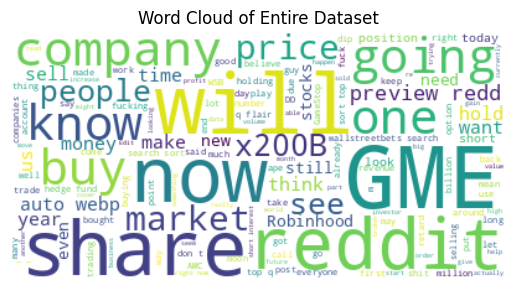

In [ ]:
# Word Cloud visualization of entire dataset
df_text = ' '.join(df['overall text'])

# STOPWORDS is standard list of stopwords, add more context specific stopwords to it
stopwords = set(STOPWORDS)
stopwords.update(['stock','nan', 's','png','stock','nan', 's','png','https','u','width','format'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(df_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Entire Dataset")
plt.axis("off")
plt.show()

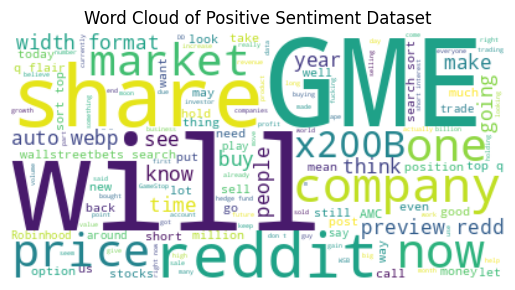

In [ ]:
# Word Cloud visualization of positive sentiment
positive_df = df[df['sentiment_category']=='positive']
positive_text = " ".join(positive_df['overall text'])
stopwords = set(STOPWORDS)
stopwords.update(['stock','nan', 's','png','https','u'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Positive Sentiment Dataset")
plt.axis("off")
plt.show()

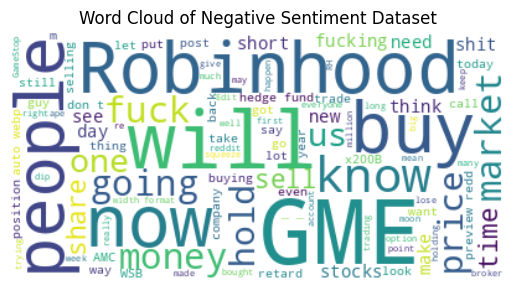

In [ ]:
# Word Cloud visualization of negative sentiment
negative_df = df[df['sentiment_category']=='negative']
negative_text = " ".join(negative_df['overall text'])
stopwords = set(STOPWORDS)
stopwords.update(['stock','nan', 's','png','https','u'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Negative Sentiment Dataset")
plt.axis("off")
plt.show()

# Topic Modeling

In [ ]:
%pip install spacy
%pip install --upgrade pyldavis
%pip install --upgrade gensim

In [ ]:
import re
from pprint import pprint
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as plt_gensim
pd.set_option('future.no_silent_downcasting', True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leevi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leevi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leevi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
 # Create list of overall text
data = df['overall text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove nan
data = [re.sub("nan", "", sent) for sent in data]

print(data[:1])

<>:5: DeprecationWarning:

invalid escape sequence '\S'

<>:8: DeprecationWarning:

invalid escape sequence '\s'

<>:5: DeprecationWarning:

invalid escape sequence '\S'

<>:8: DeprecationWarning:

invalid escape sequence '\s'

C:\Users\leevi\AppData\Local\Temp\ipykernel_8876\837703303.py:5: DeprecationWarning:

invalid escape sequence '\S'

C:\Users\leevi\AppData\Local\Temp\ipykernel_8876\837703303.py:8: DeprecationWarning:

invalid escape sequence '\s'



['Its not about the money, its about sending a message. 🚀💎🙌 ']


In [ ]:
# Convert sentences to list of single words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['its', 'not', 'about', 'the', 'money', 'its', 'about', 'sending', 'message']]


In [ ]:
# Build the bigram and trigram models, trigram is built on top of bigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# See trigram example
print(trigram[bigram[data_words[0]]])

['its', 'not', 'about', 'the', 'money', 'its', 'about', 'sending_message']


In [ ]:
# Convert LazyCorpusLoader object to a list
stopwords = list(stopwords.words('english'))

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Download spacy package for efficency
!python -m spacy download en_core_web_sm

                                              0.0/12.8 MB ? eta -:--:--
     -                                        0.5/12.8 MB 15.2 MB/s eta 0:00:01
     --                                       0.8/12.8 MB 10.6 MB/s eta 0:00:02
     -----                                    1.8/12.8 MB 14.5 MB/s eta 0:00:01
     -------                                  2.4/12.8 MB 13.6 MB/s eta 0:00:01
     --------                                 2.6/12.8 MB 11.7 MB/s eta 0:00:01
     --------                                 2.7/12.8 MB 10.0 MB/s eta 0:00:02
     --------                                 2.7/12.8 MB 9.1 MB/s eta 0:00:02
     --------                                 2.8/12.8 MB 7.7 MB/s eta 0:00:02
     --------                                 2.9/12.8 MB 7.0 MB/s eta 0:00:02
     ---------                                3.0/12.8 MB 6.5 MB/s eta 0:00:02
     ---------                                3.1/12.8 MB 6.2 MB/s eta 0:00:02
     ----------                               3.2/12.


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['money', 'sending_message']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.106*"com" + 0.088*"https" + 0.060*"reddit" + 0.050*"www" + '
  '0.039*"earning" + 0.035*"new" + 0.027*"week" + 0.022*"restrict_sr" + '
  '0.015*"wallstreetbets_search_sort" + 0.013*"day_best_weekly"'),
 (1,
  '0.029*"go" + 0.021*"get" + 0.018*"stock" + 0.018*"buy" + 0.017*"make" + '
  '0.013*"see" + 0.013*"sell" + 0.012*"think" + 0.012*"time" + 0.012*"know"'),
 (2,
  '0.053*"launch" + 0.035*"ipo" + 0.035*"accord" + 0.031*"fee" + 0.028*"view" '
  '+ 0.024*"private" + 0.023*"regard" + 0.021*"fice" + 0.021*"blow" + '
  '0.020*"segment"'),
 (3,
  '0.070*"wish" + 0.048*"sector" + 0.044*"ape" + 0.040*"important" + '
  '0.025*"enter" + 0.025*"test" + 0.022*"rkt" + 0.020*"mortgage" + '
  '0.018*"impact" + 0.017*"study"'),
 (4,
  '0.082*"company" + 0.031*"growth" + 0.017*"product" + 0.015*"industry" + '
  '0.011*"compare" + 0.011*"cap" + 0.010*"currently" + 0.010*"recent" + '
  '0.009*"covid" + 0.008*"vehicle"'),
 (5,
  '0.056*"year" + 0.014*"sale" + 0.013*"good" + 0.012*"great" + 0.0

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = plt_gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.292957  0.020074       1        1  35.273598
6     -0.274459  0.071141       2        1  33.384741
5     -0.079060  0.061337       3        1  11.644076
4      0.176549  0.109580       4        1   8.511992
0      0.058431 -0.440213       5        1   8.123144
3      0.209777  0.087956       6        1   1.910891
2      0.201719  0.090125       7        1   1.151558, topic_info=           Term          Freq         Total Category  logprob  loglift
27          com  23183.000000  23183.000000  Default  30.0000  30.0000
298       https  19251.000000  19251.000000  Default  29.0000  29.0000
233     company  18720.000000  18720.000000  Default  28.0000  28.0000
333        year  17816.000000  17816.000000  Default  27.0000  27.0000
559      reddit  13064.000000  13064.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2100      frame    231.388291    231.821713   Topic7  -4.8944   4.4622
3758   planning    219.306894    219.739838   Topic7  -4.9480   4.4621
19528  aircraft    209.828561    210.260790   Topic7  -4.9922   4.4620
38717  poshmark    534.929055    566.282108   Topic7  -4.0563   4.4071
7462     micron    261.526158    265.812777   Topic7  -4.7719   4.4478

[287 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2214      6  1.000131     absolute
1999      7  0.999930       accord
1023      1  0.999898      account
3473      7  0.999635      achieve
3562      4  0.999966  acquisition
...     ...       ...          ...
924       3  0.999955        world
332       5  0.999990          www
333       2  0.010721         year
333       3  0.989272         year
2894      7  0.996730        young

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 5, 1, 4, 3])